In [1]:
!python -V

Python 3.7.11


In [2]:
import time
start = time.time()

#Common module parameters:
NUMPY_RANDOM_SEED=10
figsize = (9, 6)

#Train validate test split (70%/15%/15%)
train_size = 0.70
valid_size=0.15

#TFT DNN:
N_ATTENTION_HEADS=4

MODEL_NAME_RNN='0v9_RNN-EPOCHS_100-48-2_g'
MODEL_NAME_LSTM='0v9_LSTM-EPOCHS_100-48-2_g'
MODEL_NAME_TCN='0v9_TCN-EPOCHS_100-48-2_g'
MODEL_NAME_GRU='0v9_GRU-EPOCHS_100-48_g'
MODEL_NAME_NBEATS='0v9_NBEATS-EPOCHS_100-48_g'
MODEL_NAME_TFT='0v9_TFT-EPOCHS_100-48_g'

#Deep Neural Network parameters:
RANDOM_STATE=31
INPUT_CHUNK_LENGTH = 48 #periods = hours
OUTPUT_CHUNK_LENGTH = 2
FORECAST_HORIZON = 2 #periods = hours

N_EPOCHS_RNN=100
N_EPOCHS_LSTM=100
N_EPOCHS_TCN=100
N_EPOCHS_GRU=100
N_EPOCHS_NBEATS=100
N_EPOCHS_TFT=100
#N_EPOCHS_TRANSFORMERS=100


# start = time.time()
# "the code you want to test stays here"
# end = time.time()
# print(end - start)

In [3]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm_notebook as tqdm


import matplotlib.pyplot as plt
import torch

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, RNNModel, TCNModel, BlockRNNModel, NBEATSModel, ARIMA
from darts.metrics import mape, rmse, r2_score, mae, mse

import warnings
warnings.filterwarnings("ignore")

import logging
logging.disable(logging.CRITICAL)

%matplotlib inline

[2022-03-02 18:30:45,050] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


In [4]:
df = pd.read_csv(r"C:\Users\User\Downloads\price-ohlc-eth-1h-final.csv", parse_dates=["timestamp"])
df['timestamp'] = pd.to_datetime(df.timestamp).dt.tz_localize(None)
nof_missing_values_o = sum(np.isnan(df['o']))
nof_missing_values_h = sum(np.isnan(df['h']))
nof_missing_values_l = sum(np.isnan(df['l']))
nof_missing_values_c = sum(np.isnan(df['c']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['o']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['h']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['l']))

df = df.fillna(method="backfill")
nof_missing_values = sum(np.isnan(df['c']))

train_index = int(len(df)*train_size)

df_train = df[0:train_index]
df_rem = df[train_index:]

valid_index = int(len(df)*valid_size)

df_val = df[train_index:train_index+valid_index]
df_test = df[train_index+valid_index:]

series = TimeSeries.from_dataframe(df, time_col='timestamp', value_cols=['c']).astype(np.float32)
series_covariates = TimeSeries.from_dataframe(df, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)
train = TimeSeries.from_dataframe(df_train, time_col='timestamp', value_cols=['c']).astype(np.float32)
train_covariates = TimeSeries.from_dataframe(df_train, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)
val = TimeSeries.from_dataframe(df_val, time_col='timestamp', value_cols=['c']).astype(np.float32)
val_covariates = TimeSeries.from_dataframe(df_val, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)
test = TimeSeries.from_dataframe(df_test, time_col='timestamp', value_cols=['c']).astype(np.float32)
test_covariates = TimeSeries.from_dataframe(df_test, time_col='timestamp', value_cols=['h','l','o']).astype(np.float32)

In [5]:
# train.plot(label="Training set Close Price")
# val.plot(label="Validation set Close Price")
# test.plot(label="Testing set Close Price")

In [6]:
# train_covariates.plot()
# val_covariates.plot()
# test_covariates.plot()

In [7]:
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
test_transformed = transformer.transform(test)
train_covariates_transformed = transformer.fit_transform(train_covariates)
val_covariates_transformed = transformer.transform(val_covariates)
test_covariates_transformed = transformer.transform(test_covariates)

In [8]:
tic_prep = time.time()
prep_elapsed_time = tic_prep - start
print(prep_elapsed_time,'seconds')

2.388409376144409 seconds


In [9]:
rnn_model = RNNModel(
    model="RNN",
    hidden_dim=20,
    dropout=0.1,
    batch_size=16,
    n_epochs=N_EPOCHS_RNN,
    optimizer_kwargs={"lr": 1e-3},
    model_name=MODEL_NAME_RNN,
    log_tensorboard=True,
    random_state=RANDOM_STATE,
    training_length=48,
    input_chunk_length=INPUT_CHUNK_LENGTH,
    force_reset=True,
    save_checkpoints=True,
)

rnn_model.fit(
    train_transformed,
    val_series=val_transformed,
    future_covariates=train_covariates_transformed,
    val_future_covariates=val_covariates_transformed,
    verbose=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
best_rnn_model = RNNModel.load_from_checkpoint(model_name=MODEL_NAME_RNN, best=True)

In [11]:
backtest_series_rnn = best_rnn_model.historical_forecasts(
    series=test_transformed,
    future_covariates=test_covariates_transformed,
    start=pd.Timestamp('2021-10-17T11:00:00'),
    forecast_horizon=FORECAST_HORIZON,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/2719 [00:00<?, ?it/s]

In [12]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("RNN:         {:.6f}".format(mse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_rnn, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_rnn, test_transformed))
# )

In [13]:
# test_transformed.plot(label="actual")
# backtest_series_rnn.plot(label="RNN")

In [14]:
tic_rnn = time.time()
rnn_elapsed_time = tic_rnn - tic_prep
print(rnn_elapsed_time,'seconds')

952.4480092525482 seconds


In [15]:
lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0.1,
    batch_size=16,
    n_epochs=N_EPOCHS_LSTM,
    optimizer_kwargs={"lr": 1e-3},
    model_name=MODEL_NAME_LSTM,
    log_tensorboard=True,
    random_state=RANDOM_STATE,
    training_length=INPUT_CHUNK_LENGTH,
    input_chunk_length=INPUT_CHUNK_LENGTH,
    force_reset=True,
    save_checkpoints=True,
)

lstm_model.fit(
    train_transformed,
    val_series=val_transformed,
    future_covariates=train_covariates_transformed,
    val_future_covariates=val_covariates_transformed,
    verbose=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
best_lstm_model = RNNModel.load_from_checkpoint(model_name=MODEL_NAME_LSTM, best=True)

In [17]:
backtest_series_lstm = best_lstm_model.historical_forecasts(
    series=test_transformed,
    future_covariates=test_covariates_transformed,
    start=pd.Timestamp('2021-10-17T11:00:00'),
    forecast_horizon=FORECAST_HORIZON,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/2719 [00:00<?, ?it/s]

In [18]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("LSTM:         {:.6f}".format(mse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_lstm, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_lstm, test_transformed))
# )

In [19]:
# test_transformed.plot(label="actual")
# backtest_series_lstm.plot(label="LSTM")

In [20]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("RNN:         {:.6f}".format(mse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_rnn, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_rnn, test_transformed))
# )
# print("LSTM:        {:.6f}".format(mse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_lstm, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_lstm, test_transformed))
# )

In [21]:
# test_transformed.plot(label="actual")
# backtest_series_rnn.plot(label="RNN")
# backtest_series_lstm.plot(label="LSTM")

In [22]:
tic_lstm = time.time()
lstm_elapsed_time = tic_lstm - tic_rnn
print(lstm_elapsed_time,'seconds')

960.9690275192261 seconds


In [23]:
tcn_model = TCNModel(
    input_chunk_length=INPUT_CHUNK_LENGTH,
    output_chunk_length=FORECAST_HORIZON,
    n_epochs=N_EPOCHS_TCN,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=RANDOM_STATE,
    force_reset=True,
    model_name=MODEL_NAME_TCN,
    log_tensorboard=True,
    save_checkpoints=True,
)

tcn_model.fit(
    series=train_transformed,
    val_series=val_transformed,
#    future_covariates=train_covariates_transformed,
#    val_future_covariates=val_covariates_transformed,
    past_covariates=train_covariates_transformed,
    val_past_covariates=val_covariates_transformed,
    verbose=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
best_tcn_model = TCNModel.load_from_checkpoint(model_name=MODEL_NAME_TCN, best=True)

In [25]:
backtest_series_tcn = best_tcn_model.historical_forecasts(
    series=test_transformed,
    past_covariates=test_covariates_transformed,
    start=pd.Timestamp('2021-10-17T11:00:00'),            
    forecast_horizon=FORECAST_HORIZON,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/2719 [00:00<?, ?it/s]

In [26]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("TCN:         {:.6f}".format(mse(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_tcn, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_tcn, test_transformed))
# )

In [27]:
# test_transformed.plot(label="actual")
# backtest_series_tcn.plot(label="TCN")

In [28]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("RNN:         {:.6f}".format(mse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_rnn, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_rnn, test_transformed))
# )
# print("LSTM:        {:.6f}".format(mse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_lstm, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_lstm, test_transformed))
# )
# print("TCN:         {:.6f}".format(mse(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_tcn, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_tcn, test_transformed))
# )

In [29]:
# test_transformed.plot(label="actual")
# backtest_series_rnn.plot(label="RNN")
# backtest_series_lstm.plot(label="LSTM")
# backtest_series_tcn.plot(label="TCN")

In [30]:
tic_tcn = time.time()
tcn_elapsed_time = tic_tcn - tic_lstm
print(tcn_elapsed_time,'seconds')

417.2058069705963 seconds


In [31]:
gru_model = BlockRNNModel(
    model="GRU",
    input_chunk_length=INPUT_CHUNK_LENGTH,
    output_chunk_length=FORECAST_HORIZON,
    hidden_size=10,
    n_rnn_layers=1,
    batch_size=32,
    n_epochs=N_EPOCHS_GRU,
    dropout=0.1,
    model_name=MODEL_NAME_GRU,
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=RANDOM_STATE,
    force_reset=True,
    save_checkpoints=True,
)

gru_model.fit(
    series=train_transformed,
    val_series=val_transformed,
#     future_covariates=train_covariates_transformed,
#     val_future_covariates=val_covariates_transformed,
    past_covariates=train_covariates_transformed,
    val_past_covariates=val_covariates_transformed,
    verbose=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
best_gru_model = BlockRNNModel.load_from_checkpoint(model_name=MODEL_NAME_TCN, best=True)

In [33]:
backtest_series_gru = best_gru_model.historical_forecasts(
    series=test_transformed,
    past_covariates=test_covariates_transformed,
    start=pd.Timestamp('2021-10-17T11:00:00'),
    forecast_horizon=FORECAST_HORIZON,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/2719 [00:00<?, ?it/s]

In [34]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("GRU:         {:.6f}".format(mse(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_gru, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_gru, test_transformed))
# )

In [35]:
# test_transformed.plot(label="actual")
# backtest_series_gru.plot(label="GRU")

In [36]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("RNN:         {:.6f}".format(mse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_rnn, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_rnn, test_transformed))
# )
# print("LSTM:        {:.6f}".format(mse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_lstm, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_lstm, test_transformed))
# )
# print("TCN:         {:.6f}".format(mse(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_tcn, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_tcn, test_transformed))
# )
# print("GRU:         {:.6f}".format(mse(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_gru, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_gru, test_transformed))
# )

In [37]:
# test_transformed.plot(label="actual")
# backtest_series_rnn.plot(label="RNN")
# backtest_series_lstm.plot(label="LSTM")
# backtest_series_tcn.plot(label="TCN")
# backtest_series_gru.plot(label="GRU")

In [38]:
tic_gru = time.time()
gru_elapsed_time = tic_gru - tic_tcn
print(gru_elapsed_time,'seconds')

550.7094163894653 seconds


In [39]:
nbeats_model = NBEATSModel(
    input_chunk_length=INPUT_CHUNK_LENGTH,
    output_chunk_length=FORECAST_HORIZON,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=N_EPOCHS_NBEATS,
    nr_epochs_val_period=1,
    batch_size=16,
    model_name=MODEL_NAME_NBEATS,
    save_checkpoints=True,
    random_state=RANDOM_STATE,
    force_reset=True,
    log_tensorboard=True,
)

nbeats_model.fit(
    series=train_transformed,
    val_series=val_transformed,
#    future_covariates=train_covariates_transformed,
#    val_future_covariates=val_covariates_transformed,
    past_covariates=train_covariates_transformed,
    val_past_covariates=val_covariates_transformed,
    verbose=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
best_nbeats_model = NBEATSModel.load_from_checkpoint(model_name=MODEL_NAME_NBEATS, best=True)

In [41]:
backtest_series_nbeats = best_nbeats_model.historical_forecasts(
    series=test_transformed,
    past_covariates=test_covariates_transformed,
    start=pd.Timestamp('2021-10-17T11:00:00'),
    forecast_horizon=FORECAST_HORIZON,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/2719 [00:00<?, ?it/s]

In [42]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("NBEATS:         {:.6f}".format(mse(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_nbeats, test_transformed))
# )

In [43]:
# test_transformed.plot(label="actual")
# backtest_series_nbeats.plot(label="NBEATS")

In [44]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("RNN:         {:.6f}".format(mse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_rnn, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_rnn, test_transformed))
# )
# print("LSTM:        {:.6f}".format(mse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_lstm, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_lstm, test_transformed))
# )
# print("TCN:         {:.6f}".format(mse(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_tcn, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_tcn, test_transformed))
# )
# print("GRU:         {:.6f}".format(mse(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_gru, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_gru, test_transformed))
# )
# print("NBEATS:      {:.6f}".format(mse(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_nbeats, test_transformed))
# )

In [45]:
# test_transformed.plot(label="actual")
# backtest_series_rnn.plot(label="RNN")
# backtest_series_lstm.plot(label="LSTM")
# backtest_series_tcn.plot(label="TCN")
# backtest_series_gru.plot(label="GRU")
# backtest_series_nbeats.plot(label="NBEATS")

In [46]:
tic_nbeats = time.time()
nbeats_elapsed_time = tic_nbeats - tic_gru
print(nbeats_elapsed_time,'seconds')

2257.2088990211487 seconds


In [47]:
tft_model = TFTModel(
    input_chunk_length=INPUT_CHUNK_LENGTH,
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    hidden_size=32,
    lstm_layers=1,
    num_attention_heads=N_ATTENTION_HEADS,
    dropout=0.1,
    batch_size=16,
    n_epochs=N_EPOCHS_TFT,
    likelihood=None,
    loss_fn=torch.nn.MSELoss(),
    random_state=RANDOM_STATE,
    add_relative_index=True,
    force_reset=True,
    model_name=MODEL_NAME_TFT,
    save_checkpoints=True,
    log_tensorboard=True,
)

tft_model.fit(
    train_transformed,
    val_series=val_transformed,
    past_covariates=train_covariates_transformed,
    val_past_covariates=val_covariates_transformed,
    verbose=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [48]:
best_tft_model = TFTModel.load_from_checkpoint(model_name=MODEL_NAME_TFT, best=True)

In [49]:
backtest_series_tft = best_tft_model.historical_forecasts(
    series=test_transformed,
    start=pd.Timestamp('2021-10-17T11:00:00'),
    past_covariates=test_covariates_transformed,
    forecast_horizon=FORECAST_HORIZON,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/2719 [00:00<?, ?it/s]

In [50]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("TFT:         {:.6f}".format(mse(backtest_series_tft, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_tft, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_tft, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_tft, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_tft, test_transformed))
# )

In [51]:
# test_transformed.plot(label="actual")
# backtest_series_tft.plot(label="TFT")

In [52]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("RNN:         {:.6f}".format(mse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_rnn, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_rnn, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_rnn, test_transformed))
# )
# print("LSTM:        {:.6f}".format(mse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_lstm, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_lstm, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_lstm, test_transformed))
# )
# print("TCN:         {:.6f}".format(mse(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_tcn, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_tcn, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_tcn, test_transformed))
# )
# print("GRU:         {:.6f}".format(mse(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_gru, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_gru, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_gru, test_transformed))
# )
# print("NBEATS:      {:.6f}".format(mse(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_nbeats, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_nbeats, test_transformed))
# )
# print("TFT:         {:.6f}".format(mse(backtest_series_tft, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_tft, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_tft, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_tft, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_tft, test_transformed))
# )

In [53]:
# test_transformed.plot(label="actual")
# backtest_series_rnn.plot(label="RNN")
# backtest_series_lstm.plot(label="LSTM")
# backtest_series_tcn.plot(label="TCN")
# backtest_series_gru.plot(label="GRU")
# backtest_series_nbeats.plot(label="NBEATS")
# backtest_series_tft.plot(label="TFT")

In [54]:
tic_tft = time.time()
tft_elapsed_time = tic_tft - tic_nbeats
print(tft_elapsed_time,'seconds')

2886.200038433075 seconds


In [55]:
arima_model = ARIMA()
arima_model.fit(train_transformed)

In [56]:
backtest_series_arima = arima_model.historical_forecasts(
    series=test_transformed,
    start=pd.Timestamp('2021-10-17T11:00:00'),
    forecast_horizon=FORECAST_HORIZON,
    stride=1,
    retrain=True,
    verbose=True,
)

  0%|          | 0/2719 [00:00<?, ?it/s]

In [57]:
# print("        Backtesting metric results - Test set with best model")
# print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
# print("ARIMA:          {:.6f}".format(mse(backtest_series_arima, test_transformed)),
#       "  {:.6f}".format(mae(backtest_series_arima, test_transformed)),
#       "  {:.6f}".format(rmse(backtest_series_arima, test_transformed)),
#       "  {:.6f}".format(r2_score(backtest_series_arima, test_transformed)),
#       "  {:.6f}%".format(mape(backtest_series_arima, test_transformed))
# )

In [58]:
# test_transformed.plot(label="actual")
# backtest_series_arima.plot(label="ARIMA")

In [59]:
tic_arima = time.time()
arima_elapsed_time = tic_arima - tic_tft
print(tft_elapsed_time,'seconds')

2886.200038433075 seconds


In [60]:
print("      Backtesting metric results - Testing set with best models")
print("Metrics         MSE", "      MAE ","     RMSE", "        R2          MAPE")
print("RNN:         {:.6f}".format(mse(backtest_series_rnn, test_transformed)),
      "  {:.6f}".format(mae(backtest_series_rnn, test_transformed)),
      "  {:.6f}".format(rmse(backtest_series_rnn, test_transformed)),
      "  {:.6f}".format(r2_score(backtest_series_rnn, test_transformed)),
      "  {:.6f}%".format(mape(backtest_series_rnn, test_transformed))
)
print("LSTM:        {:.6f}".format(mse(backtest_series_lstm, test_transformed)),
      "  {:.6f}".format(mae(backtest_series_lstm, test_transformed)),
      "  {:.6f}".format(rmse(backtest_series_lstm, test_transformed)),
      "  {:.6f}".format(r2_score(backtest_series_lstm, test_transformed)),
      "  {:.6f}%".format(mape(backtest_series_lstm, test_transformed))
)
print("TCN:         {:.6f}".format(mse(backtest_series_tcn, test_transformed)),
      "  {:.6f}".format(mae(backtest_series_tcn, test_transformed)),
      "  {:.6f}".format(rmse(backtest_series_tcn, test_transformed)),
      "  {:.6f}".format(r2_score(backtest_series_tcn, test_transformed)),
      "  {:.6f}%".format(mape(backtest_series_tcn, test_transformed))
)
print("GRU:         {:.6f}".format(mse(backtest_series_gru, test_transformed)),
      "  {:.6f}".format(mae(backtest_series_gru, test_transformed)),
      "  {:.6f}".format(rmse(backtest_series_gru, test_transformed)),
      "  {:.6f}".format(r2_score(backtest_series_gru, test_transformed)),
      "  {:.6f}%".format(mape(backtest_series_gru, test_transformed))
)
print("NBEATS:      {:.6f}".format(mse(backtest_series_nbeats, test_transformed)),
      "  {:.6f}".format(mae(backtest_series_nbeats, test_transformed)),
      "  {:.6f}".format(rmse(backtest_series_nbeats, test_transformed)),
      "  {:.6f}".format(r2_score(backtest_series_nbeats, test_transformed)),
      "  {:.6f}%".format(mape(backtest_series_nbeats, test_transformed))
)
print("TFT:         {:.6f}".format(mse(backtest_series_tft, test_transformed)),
      "  {:.6f}".format(mae(backtest_series_tft, test_transformed)),
      "  {:.6f}".format(rmse(backtest_series_tft, test_transformed)),
      "  {:.6f}".format(r2_score(backtest_series_tft, test_transformed)),
      "  {:.6f}%".format(mape(backtest_series_tft, test_transformed))
)
print("ARIMA:       {:.6f}".format(mse(backtest_series_arima, test_transformed)),
      "  {:.6f}".format(mae(backtest_series_arima, test_transformed)),
      "  {:.6f}".format(rmse(backtest_series_arima, test_transformed)),
      "  {:.6f}".format(r2_score(backtest_series_arima, test_transformed)),
      "  {:.6f}%".format(mape(backtest_series_arima, test_transformed))
)

      Backtesting metric results - Testing set with best models
Metrics         MSE       MAE       RMSE         R2          MAPE
RNN:         0.000010   0.002320   0.003139   0.999582   0.260124%
LSTM:        0.000008   0.001997   0.002754   0.999681   0.228815%
TCN:         0.000109   0.007218   0.010427   0.995431   0.845724%
GRU:         0.000109   0.007218   0.010427   0.995431   0.845724%
NBEATS:      0.000116   0.007478   0.010773   0.995084   0.877596%
TFT:         0.001577   0.025322   0.039708   0.916856   2.783343%
ARIMA:       0.000108   0.007276   0.010389   0.995466   0.850972%


Text(0, 0.5, 'Normalized ETH close value')

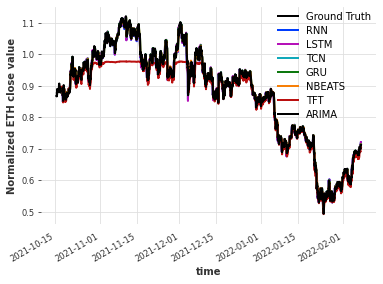

In [61]:
test_transformed.plot(label="Ground Truth")
backtest_series_rnn.plot(label="RNN")
backtest_series_lstm.plot(label="LSTM")
backtest_series_tcn.plot(label="TCN")
backtest_series_gru.plot(label="GRU")
backtest_series_nbeats.plot(label="NBEATS")
backtest_series_tft.plot(label="TFT")
backtest_series_arima.plot(label="ARIMA")
figsize = (36, 24)
plt.legend(
           borderpad=0,
           labelspacing=0.4,
           title_fontsize='large',
           shadow=False,
           frameon=False,
           loc='best'  
          )
plt.ylabel('Normalized ETH close value')

In [62]:
print('--------Processing Time (seconds)-----------')
print('Preparation:     ',prep_elapsed_time,'seconds')
print('RNN model:     ', rnn_elapsed_time,' seconds')
print('LSTM model:    ',lstm_elapsed_time,' seconds')
print('TCN model:      ',tcn_elapsed_time,' seconds')
print('GRU model:      ',gru_elapsed_time,' seconds')
print('NBEATS model:  ',nbeats_elapsed_time, '  seconds')
print('TFT model:     ',tft_elapsed_time,'  seconds')
print('ARIMA model:  ',arima_elapsed_time,'  seconds')

--------Processing Time (seconds)-----------
Preparation:      2.388409376144409 seconds
RNN model:      952.4480092525482  seconds
LSTM model:     960.9690275192261  seconds
TCN model:       417.2058069705963  seconds
GRU model:       550.7094163894653  seconds
NBEATS model:   2257.2088990211487   seconds
TFT model:      2886.200038433075   seconds
ARIMA model:   1690.740665435791   seconds
